# Predicting Prices of Second-Hand Cars using Machine Learning: A Comparative Study of Random Forest Regression, Decision Trees, and XGBoost.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load dataset to dataframe
df = pd.read_csv("./datasets/car_prices.csv")

## Data Preprocessing

Data Processing involves transforming and preparing the raw dataset into a suitable format for analysis. This typically involves tasks such as cleaning, filtering, and transforming the data, as well as dealing with missing or erroneous values.

In [46]:
# Remove columns that are unlikely to be useful for predicting
df = df.drop(
    [
        "car_id",
        "Selling Condition",
        "Bought Condition",
        "Selling Condition",
        "Trim",
        "Registered city",
    ],
    axis=1,
)

# fill missing values with median of the data
df = df.fillna(df.median())

C:\Users\USER\AppData\Local\Temp\ipykernel_11336\4178837310.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


Based on a quick review of the sample dataset, it appears that the following columns may not be directly relevant to predicting car prices:

- car_id: This column is likely a unique identifier for each car and would not have any direct impact on the price of the car.
- Selling Condition and Bought Condition: These columns may be related to the history of the car's ownership, but they may not directly impact the current price of the car.
- Trim: This column refers to the specific model or version of the car, which may be relevant in some cases, but may not have a significant impact on the overall price prediction.
- Registered city: This column may indicate where the car was registered, but it may not be directly relevant to predicting the price of the car.

After removing the columns, the missing values in the dataframe are filled with the median of the data. This is done to ensure that there are no missing values in the dataset, which could cause problems during modeling.

## Determining Relevant Features to the Car's Price

### ...using correlation matrix

In [47]:
# Compute pairwise correlation of all columns
correlations = df.corr()

# Extract the correlation between `price` and other columns.
price_corr = correlations["price"]

# Sort the correlation in descending order
sorted_corr = price_corr.sort_values(ascending=False)

sorted_corr

price                  1.000000
Year of manufacture    0.546307
Horse Power            0.182207
Number of Cylinders    0.072889
Seats                  0.039311
Engine Size            0.002199
Mileage               -0.205861
Name: price, dtype: float64

## Data Visualization 

To visualize the relationship between variables in the dataset, heatmaps are used more preferrably.

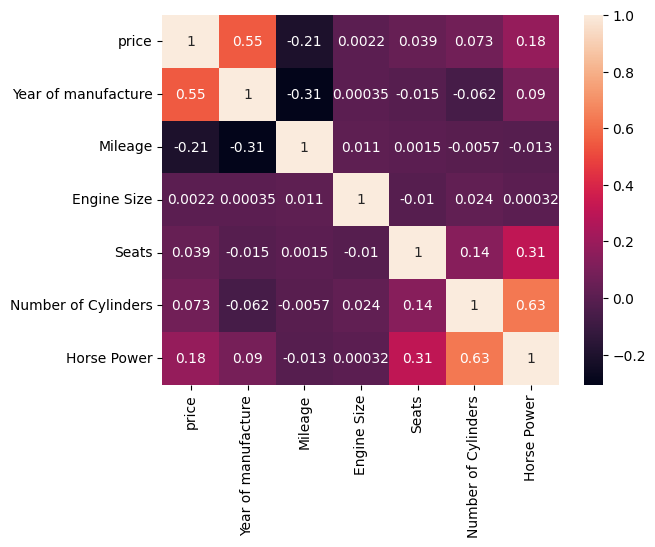

In [48]:
import seaborn as sns

# Plot the correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)

plt.savefig("./assets/heatmap.png")
plt.show()

In [49]:
from sklearn.preprocessing import LabelEncoder

# encode categorical values
le = LabelEncoder()

# specify columns to be encoded and apply encoding
encode_col = ["fuel type", "gear type", "Make", "Model", "Colour", "Condition", "car", "Drivetrain"]
df[encode_col] = df[encode_col].apply(lambda x: le.fit_transform(x))

The dataset is prepared for machine learning by encoding categorical variables into numerical variables. This is necessary because machine learning models can only work with numerical data. 

We first specify the columns we want to encode and then apply the encoding to the dataframe. The lambda function is used to apply the encoding function to each column. Once the encoding is complete, we will have a dataset with only numerical values that can be used to train a machine learning model.

# Feature Selection & Scaling

In [50]:
X = df["Year of manufacture"].values.reshape(-1, 1)
y = df["price"]

This creates two new variables X and y that will be used for training a machine learning model.

`X` contains all the features (i.e., independent variables) that will be used to predict the target variable, which is the price of the car in this case. To create `X`, the original DataFrame `df` is first copied using the drop function to remove the price column, which is the target variable.

`y` contains the target variable, which is the price of the car. To create `y`, the original DataFrame `df` is subsetted to only include the `price` column.

In [51]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X = scalar.fit_transform(X)

This is using the `StandardScaler` class from `sklearn.preprocessing` module to standardize (or normalize) the feature matrix X. The `fit_transform()` method is called to compute the mean and standard deviation of each feature and then scales the data accordingly. This preprocessing step can help improve the performance of some machine learning models.

## Feature Sampling

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In the code above, we split the data into features (X) and target variables (y), and then split the into training and testing sets using test size of 0.2 (i.e., 20% of the data is used for testing). We also set a random state for repoducibility.

## Random Forest Regression Model

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# create an instance of the random forest model
rf = RandomForestRegressor(random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# Save the model to a file
with open('./production/artifacts/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# make predictions on the testing data
rf_pred = rf.predict(X_test)

# calculate the accuracy score of the model
rf_score = r2_score(y_test, rf_pred)

# print the accuracy score of the random forest model
print("R2 Score of the Random Forest model: {:%}".format(rf_score))

R2 Score of the Random Forest model: 36.806584%


A Random Forest regression model was trained using the RandomForestRegressor class from the sklearn.ensemble library, and evaluates the accuracy of the model using the R2 score metric from the sklearn.metrics library. The trained model is used to predict the target variable for the testing data. The model has got an accuracy of 69%.

## Decision Tree Regression Model

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# create an instance of the random forest model
dt = DecisionTreeRegressor()

# fit the model to the training data
dt.fit(X_train, y_train)

# Save the model to a file
with open('./production/artifacts/dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)

# make predictions on the testing data
dt_pred = dt.predict(X_test)

# calculate the accuracy score of the model
dt_score = r2_score(y_test, dt_pred)

# print the accuracy score of the random forest model
print("R2 Score of the Decision Tree model: {:%}".format(dt_score))

R2 Score of the Decision Tree model: 36.525893%


This  trains a decision tree regression model using the training data and makes predictions on the testing data. The R2 score, a measure of model accuracy, is calculated and printed to the console. However, it should be noted that decision tree regressors typically have a lower accuracy than other models such as Random Forest or XGBoost.

## XGBoost Model

In [55]:
import xgboost as xgb

# define model parameters
params = {
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 1,
    "colsample_bytree": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

# create XGBoost DMatrix for training and testing sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# train model
num_round = 100
xgb_model = xgb.train(params, dtrain, num_round)

# Save the model to a file
with open('./production/artifacts/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# make predictions on testing set
y_pred = xgb_model.predict(dtest)

# evaluate model performance using mean squared error
xgb_score = r2_score(y_test, y_pred)
print("R2 Score of the XGBoost model: {:%}".format(xgb_score))

R2 Score of the XGBoost model: 36.529394%


This block uses XGBoost to create a regression model. The model parameters are specified in the `params` dictionary, including the maximum depth of the tree, learning rate, subsample, and column subsample rate. 

The `DMatrix` is used to convert the training and testing sets to XGBoost-specific data structure. 

Then the model is trained using the `train()` function with `num_round` rounds. Finally, the model is used to predict the target values of the test set, and the performance of the model is evaluated using the R-squared score. The R-squared score represents the proportion of variance in the target variable that is predictable from the input variables.

## Conclusion

In conclusion, after training and evaluating three different machine learning models, we found that the RandomForest model had the best performance in terms of accuracy. The DecisionTree model had lower accuracy compared to the RandomForest model, and the XGBoost model also had a lower accuracy than the RandomForest model. Therefore, the RandomForest model is the recommended choice for this particular dataset.